In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from scipy import stats
from scipy.stats import spearmanr

In [219]:
# read in data
df_eng = pd.read_csv('tutor_data.csv').drop(columns='Unnamed: 0')
df_eng.reset_index(drop=True, inplace=True)
#df_eng.drop_duplicates(inplace=True)

df_nlp = pd.read_csv('tutor_nlp.csv')
df_eng = pd.concat([df_eng, df_nlp], axis=1)

# cuts on targets
df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] < 20].index]
df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] > 0.5].index]
df_eng = df_eng.loc[df_eng[df_eng['hours_tutor'] <= 1000].index]

df_eng = df_eng.loc[df_eng[df_eng['rate'] <= 200].index]
df_eng = df_eng.loc[df_eng[df_eng['rate'] >= 20].index]

In [220]:
df_eng['hours_per_week_estimate'].describe()

count    2492.000000
mean        2.388819
std         2.572551
min         0.500801
25%         0.906575
50%         1.514402
75%         2.749769
max        19.544248
Name: hours_per_week_estimate, dtype: float64

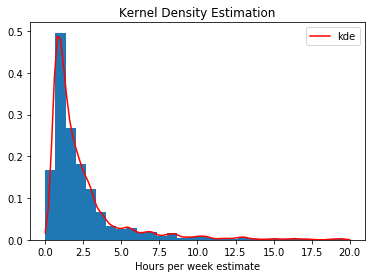

In [221]:
plt.hist(df_eng.hours_per_week_estimate, bins=30, range=(0,20), density=True)
plt.xlabel('Hours per week estimate')
gkde = stats.gaussian_kde(df_eng.hours_per_week_estimate, bw_method = 0.1, weights=None)
ind = np.linspace(0,20,101)
kdepdf = gkde.evaluate(ind)
#plt.figure()
plt.plot(ind, kdepdf, label='kde', color="r")
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

In [222]:
def string_to_list(i):
    x = i.replace('[', '').replace(']', '').replace('\'', '').split(',')
    list_i = list()
    for j in x:
        list_i.append(j.lstrip().rstrip())
    return list_i

subjects_all_list = []
for i in df_eng['subjects_all']:
    subjects_all_list.append(string_to_list(i))
df_eng['subjects_list'] = np.array(subjects_all_list)

subjects_emph_list = []
for i in df_eng['subjects_emph']:
    subjects_emph_list.append(string_to_list(i))
df_eng['subjects_emph_list'] = np.array(subjects_emph_list)

#edu_list = []
#for i in df_eng['edu']:
#    edu_list.append(string_to_list(i))
#df_eng['edu_list'] = np.array(edu_list)

# engineer subjects categories

feature = 'subjects_list'
size_subjects = len(df_eng[feature].explode().value_counts().index)
popular_subjects = list(df_eng[feature].explode().value_counts().index[:size_subjects//3])
mid_subjects = list(df_eng[feature].explode().value_counts().index[size_subjects//3:(size_subjects//3 + size_subjects//3)])
unpopular_subjects = list(df_eng[feature].explode().value_counts().index[(size_subjects//3 + size_subjects//3):])

unwanted = ''
if unwanted in popular_subjects:
    popular_subjects.remove(unwanted)
elif unwanted in mid_subjects:
    mid_subjects.remove(unwanted)
elif unwanted in unpopular_subjects:
    unpopular_subjects.remove(unwanted)

popular_list = []
mid_list = []
unpopular_list = []
for f in df_eng[feature]:
    num_popular = 0
    num_mid = 0
    num_unpopular = 0
    for j in f:
        if j in popular_subjects:
            num_popular += 1
        elif j in mid_subjects:
            num_mid += 1
        elif j in unpopular_subjects:
            num_unpopular += 1
    popular_list.append(num_popular)
    mid_list.append(num_mid)
    unpopular_list.append(num_unpopular)
    
df_eng['num_popular_subjects'] = np.array(popular_list)
df_eng['num_mid_subjects'] = np.array(mid_list)
df_eng['num_unpopular_subjects'] = np.array(unpopular_list)

# engineer edu degree categories

undergrad = ['BA', 'B.A.', 'BS', 'B.S.', '']
postgrad = ['MS', 'M.S', 'MA', 'M.A', 'masters', 'Masters', 'CA', 'C.A', 
            'MBA', 'M.B.A', 'MD', 'M.D', 'PhD', 'Ph.D', 'Ph.D.', 'Graduate']
certified = ['education', 'Ced', 'certified']

undergrad_degree = []
postgrad_degree = []
certified_degree = []
for e in df_eng['edu']:
    undergrad_count = 0
    postgrad_count = 0
    certified_count = 0
    if any(x in e for x in undergrad):
        undergrad_count += 1
    if any(x in e for x in postgrad):
        postgrad_count += 1
    if any(x in e for x in certified):
        certified_count +=1
    undergrad_degree.append(undergrad_count)
    postgrad_degree.append(postgrad_count)
    certified_degree.append(certified_count)
df_eng['undergrad_degree'] = np.array(undergrad_degree)
df_eng['postgrad_degree'] = np.array(postgrad_degree)
df_eng['certified_degree'] = np.array(certified_degree)

# get university rankings
df_wur = pd.read_csv('world-university-rankings_cwurData.csv')
df_wur_select = df_wur[['institution', 'world_rank']]

list_of_top_schools = (list(df_wur_select['institution'][:30]) + 
['Berkeley', 'Caltech', 'Harvard', 'Yale', 'Princeton', 'MIT', 'Stanford'])

top_school = []
for e in df_eng['edu']:
    top = 0
    if any(x in e for x in list_of_top_schools):
        top += 1
    top_school.append(top)
df_eng['top_school'] = np.array(top_school)

df_eng['bio_count'] = df_eng['bio'].apply(lambda x: len(str(x).split(" ")))
df_eng['desc_count'] = df_eng['descriptions'].apply(lambda x: len(str(x).split(" ")))

In [223]:
cols_to_drop = ['descriptions', 'bio', 'subjects_list', 'subjects_emph_list', 
                'edu', 'bg_check_date', 'earliest_review_date', 
                'subjects_emph', 'subjects_all','hours_tutor', 
                'num_ratings', 'review_dates', 'earliest_date','undergrad_degree',
               'hours_mon', 'hours_tues', 'hours_wed', 'hours_thurs', 'hours_fri']

cols_importance = ['hours_thurs', 'hours_mon', 'hours_tues', 'hours_wed', 'hours_fri', 'hours_sat', 'hours_sun', 
                    'postgrad_degree', 'num_mid_subjects', 'num_unpopular_subjects', 'certified_degree', 
               'number_subjects', 'desc_count', 'goal_kw', 'experience_kw']

X = df_eng.drop(columns=(['hours_per_week_estimate'] + cols_to_drop))
y = df_eng.hours_per_week_estimate

#Take the log of y
y_log = np.log10(y)

#rescale data
X = (X - X.min()) / (X.max()-X.min())

features = X.columns

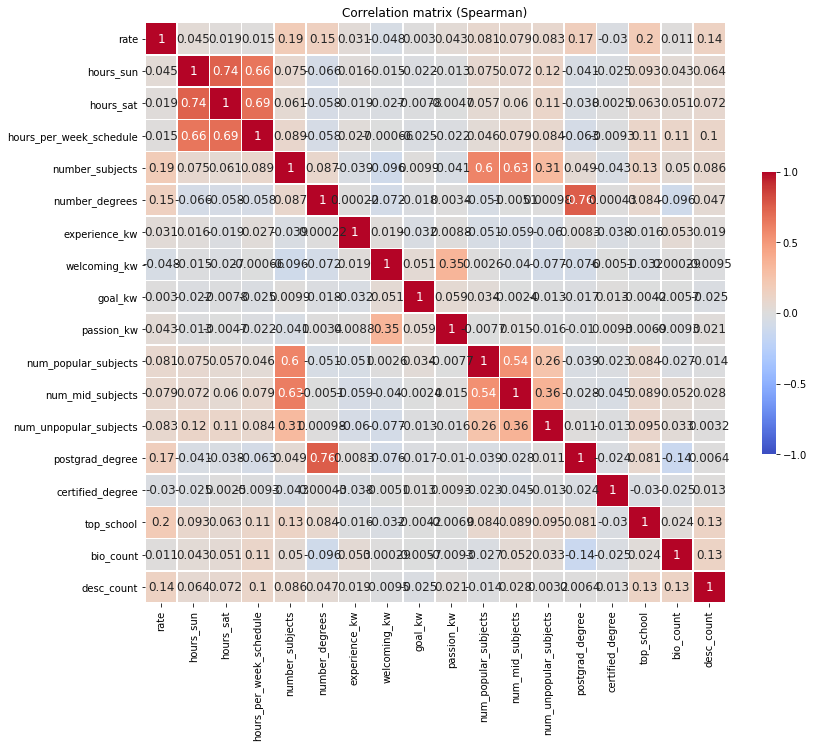

In [224]:
# Plot Spearman Correlation matrix

fig, ax = plt.subplots(figsize=(13, 13)) 

spearman_corr = pd.DataFrame(spearmanr(X).correlation, index=features, columns=features)

spearman_heatmap = sns.heatmap(spearman_corr,
                     square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
ax.set_yticklabels(spearman_corr.columns, rotation = 0)
ax.set_xticklabels(spearman_corr.columns)
ax.set_title('Correlation matrix (Spearman)')
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

0.07056254509690196


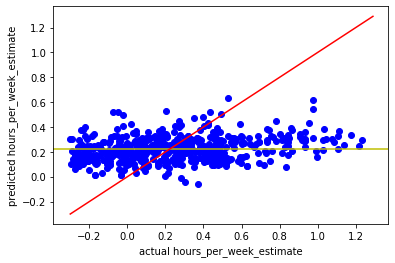

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
model = Ridge(alpha=1e-2).fit(X_train, y_train)
y_predict = model.predict(X_test)

print(model.score(X_test, y_test))

plt.scatter(np.array(y_test), y_predict, color='b')
plt.axhline(y=y_log.mean(), color='y', linestyle='-')
x = np.linspace(y_log.min(), y_log.max(),100)
plt.plot(x, x, '-r')

plt.xlabel('actual hours_per_week_estimate')
plt.ylabel('predicted hours_per_week_estimate')

plt.show()

r^2:  0.22150950721357188


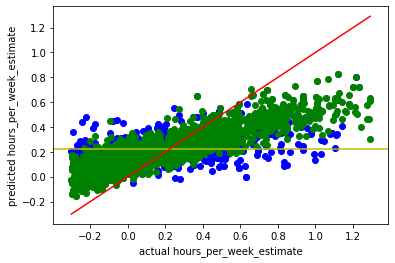

In [226]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
y_fit = rf.predict(X_train)

print('r^2: ', r2_score(y_test, y_predict))
plt.scatter(np.array(y_test), y_predict, color='b')
plt.scatter(np.array(y_train), y_fit, color='g')
plt.axhline(y=y_log.mean(), color='y', linestyle='-')
x = np.linspace(y_log.min(), y_log.max(),100)
plt.plot(x, x, '-r')

plt.xlabel('actual hours_per_week_estimate')
plt.ylabel('predicted hours_per_week_estimate')
plt.show()

Feature ranking:
feature bio_count (0.15)
feature hours_per_week_schedule (0.13)
feature rate (0.11)
feature number_subjects (0.09)
feature num_popular_subjects (0.07)
feature desc_count (0.07)
feature welcoming_kw (0.06)
feature hours_sun (0.06)
feature hours_sat (0.06)
feature num_mid_subjects (0.04)
feature passion_kw (0.04)
feature experience_kw (0.04)
feature num_unpopular_subjects (0.03)
feature number_degrees (0.02)
feature top_school (0.01)
feature postgrad_degree (0.01)
feature goal_kw (0.01)
feature certified_degree (0.00)


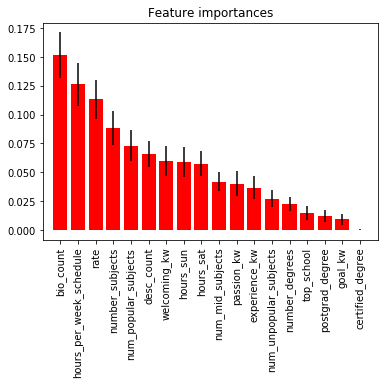

In [227]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0)
features = list(X.columns)
rf.fit(X, y_log)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%.2f)" %(test[f], importances[indices[f]]))

# Plot feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [228]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)
features = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
perm.fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1460 ± 0.0259,hours_per_week_schedule
0.0965 ± 0.0231,bio_count
0.0770 ± 0.0168,rate
0.0389 ± 0.0176,number_subjects
0.0291 ± 0.0094,welcoming_kw
0.0285 ± 0.0045,hours_sat
0.0264 ± 0.0124,desc_count
0.0249 ± 0.0072,hours_sun
0.0198 ± 0.0124,num_unpopular_subjects
0.0186 ± 0.0037,num_popular_subjects


In [258]:
important_features = ['hours_per_week_schedule', 'bio_count', 'rate', 'number_subjects', 'welcoming_kw',
                     'num_popular_subjects', 'experience_kw', 'top_school']

In [259]:
for i in range(len(important_features)):   
    X_sub = X[important_features[:(i+1)]]
    knn = KNeighborsRegressor(weights='distance', n_neighbors = 3)
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_log, test_size=0.2, random_state=0)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    print(i+1, ' features', ' ', r2_score(y_test, y_predict))

1  features   -0.20016530166421043
2  features   0.10298596348397926
3  features   0.015488066134394018
4  features   -0.010746999686882086
5  features   0.004586512324412428
6  features   0.009078299940024737
7  features   0.002574555632727682
8  features   -0.010314546794538915
